## Importing dependencies

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# 1. Prepare Features and Target

In [4]:
df = pd.read_csv("diabetes_dataset_enhanced.csv")

In [5]:
df.head()

,ID,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,...,Education,Income,Has_High_Risk_Factor,Cardio_History,Risky_Habits,Healthy_Lifestyle_Score,Total_Unhealthy_Days,BMI_Category,GenHlth_Binary,Age_Group
0,0,0,1,1,1,40,1,0,0,0,...,4,3,1,0,1,1,33,Obese,0,60+
1,1,0,0,0,0,25,1,0,0,1,...,6,1,1,0,1,1,0,Overweight,1,45-59
2,2,0,1,1,1,28,0,0,0,0,...,4,8,1,0,0,1,60,Overweight,0,60+
3,3,0,1,0,1,27,0,0,0,1,...,3,6,1,0,0,3,0,Overweight,1,60+
4,4,0,1,1,1,24,0,0,0,1,...,5,4,1,0,0,3,3,Normal,1,60+


In [6]:
df = df.drop(columns=['ID'])  # Drop ID

x = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

In [7]:
y

0         0
1         0
2         0
3         0
4         0
         ..
253675    0
253676    1
253677    0
253678    0
253679    1
Name: Diabetes_binary, Length: 253680, dtype: int64

In [8]:
# One-hot encode categorical variables (BMI_Category, Age_Group)
X = pd.get_dummies(x, drop_first=True)

## 2. Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Scaling

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Feature Selection

In [11]:
# Consistently using DataFrames (with feature names)
k_best = SelectKBest(score_func=f_classif, k=25)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)


selected_features = X.columns[k_best.get_support()]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income',
       'Has_High_Risk_Factor', 'Cardio_History', 'Healthy_Lifestyle_Score',
       'Total_Unhealthy_Days', 'GenHlth_Binary', 'BMI_Category_Obese',
       'BMI_Category_Overweight', 'Age_Group_30-44', 'Age_Group_60+'],
      dtype='object')


## 5. XGBoost + Hyperparameter Tuning

In [12]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
}

grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_selected, y_train)

print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\diabetes_prediction\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


## 6. Final Model Training

In [13]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_selected)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     43667
           1       0.57      0.15      0.23      7069

    accuracy                           0.87     50736
   macro avg       0.72      0.56      0.58     50736
weighted avg       0.83      0.87      0.83     50736

Accuracy: 0.8656378114159571


### 👉 Confusion Matrix

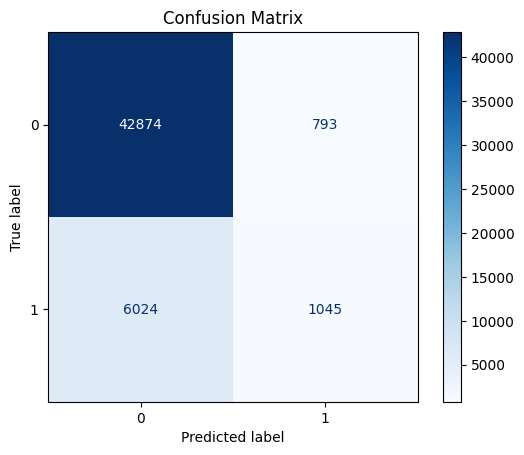

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [15]:
y_pred = best_model.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[42874   793]
 [ 6024  1045]]


# saving the model

In [16]:
import joblib
# 👉 Save the model
joblib.dump(best_model, 'xgboost_diabetes_model.pkl')

['xgboost_diabetes_model.pkl']

In [17]:
X_test.to_csv('X_test_selected.csv', index=False)

In [18]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Education,Income,Has_High_Risk_Factor,Cardio_History,Risky_Habits,Healthy_Lifestyle_Score,Total_Unhealthy_Days,BMI_Category,GenHlth_Binary,Age_Group
0,0,1,1,1,40,1,0,0,0,0,...,4,3,1,0,1,1,33,Obese,0,60+
1,0,0,0,0,25,1,0,0,1,0,...,6,1,1,0,1,1,0,Overweight,1,45-59
2,0,1,1,1,28,0,0,0,0,1,...,4,8,1,0,0,1,60,Overweight,0,60+
3,0,1,0,1,27,0,0,0,1,1,...,3,6,1,0,0,3,0,Overweight,1,60+
4,0,1,1,1,24,0,0,0,1,1,...,5,4,1,0,0,3,3,Normal,1,60+


In [20]:
import joblib
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

# 👇 Assuming X_train and y_train were used for training
# Re-initialize and fit SelectKBest with k=25
selector = SelectKBest(score_func=f_classif, k=25)
selector.fit(X_train, y_train)

# Transform X_test using the fitted selector
X_test_selected = selector.transform(X_test)

# 👉 Save the model
joblib.dump(best_model, 'xgboost_diabetes_model.pkl')
joblib.dump(selector, 'selectkbest_25.pkl')  # Save the feature selector as well

# 👉 Load & Test the model
loaded_model = joblib.load('xgboost_diabetes_model.pkl')
loaded_selector = joblib.load('selectkbest_25.pkl')

# Transform test data again (safe practice)
X_test_selected_loaded = loaded_selector.transform(X_test)
y_loaded_pred = loaded_model.predict(X_test_selected_loaded)

# Optional: Display classification report again
print(classification_report(y_test, y_loaded_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43667
           1       0.57      0.15      0.23      7069

    accuracy                           0.87     50736
   macro avg       0.72      0.56      0.58     50736
weighted avg       0.83      0.87      0.83     50736

